# Learning curves - Compare ML models
This code generates learning curve from the output of multiple runs of ... <br>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

# New scripts

In [2]:
# save = True
save = False
if save:
    outdir = Path('post_proc')
    os.makedirs(outdir, exist_ok=True)

In [3]:
# src_name = 'ccle'
# src_name = 'gdsc'
src_name = 'top6'

In [4]:
# CCLE
if src_name == 'ccle':
    desc = [('combat_lgb_reg',     'ccle.lgb_reg.cvf5.rna.dsc.AUC_2019-7-5_h12-m55'),
            ('combat_nn_reg0_clr', 'ccle.nn_reg0.clr.cvf5.rna.dsc.AUC_2019-7-5_h14-m50'),
    ]

# GDSC
if src_name == 'gdsc':
    desc = [('lgb_reg',           'gdsc.lgb_reg.cvf5.rna.dsc.AUC_2019-6-20_h11-m24'),
            
            #('raw_lgb_reg',             'gdsc.lgb_reg.cvf5.rna.dsc.AUC_2019-7-2_h16-m59'),
            #('raw_no_fibro_lgb_reg',    'gdsc.lgb_reg.cvf5.rna.dsc.AUC_2019-7-2_h17-m0'),
            ('combat_lgb_reg',          'gdsc.lgb_reg.cvf5.rna.dsc.AUC_2019-7-2_h17-m37'),
            #('combat_no_fibro_lgb_reg', 'gdsc.lgb_reg.cvf5.rna.dsc.AUC_2019-7-2_h17-m43'),
            ('combat_nn_reg0', 'gdsc.nn_reg0.clr.cvf5.rna.dsc.AUC_2019-7-6_h9-m16')
    ]

# Top6
if src_name == 'top6':
    desc = [('lgb_reg',       'top6.lgb_reg.cvf5.rna.dsc.AUC1_2019-6-20_h15-m29'),
            ('nn_model0_sgd', 'top6.nn_model0.sgd.cvf5.rna.dsc.AUC1_2019-6-21_h23-m20'),
            ('nn_model1_sgd', 'top6.nn_model1.sgd.cvf5.rna.dsc.AUC1_2019-6-22_h22-m44'),
            #('nn_model0_clr', 'top6.nn_model0.clr.cvf5.rna.dsc.AUC1_2019-6-20_h16-m49'),
            #('nn_model1_clr', 'top6.nn_model1.clr.cvf5.rna.dsc.AUC1_2019-6-20_h16-m50'),
            
            #('lgb_reg_code', 'topNcode.lgb_reg.cvf5.rna.dsc.AUC_2019-7-2_h15-m29'),
           ]

datadir = '../../out'
prj = 'lrn_crv'

# Models
runs = {}
for i, v in enumerate(desc):
    runs[f'run{i}'] = (v[0], Path.cwd()/datadir/prj/v[1]/f'lrn_crv_scores.csv')
    
# runs = {'run1': (desc[0][0], Path.cwd()/datadir/prj/desc[0][1]/f'lrn_crv_scores_{src_name}.csv'),
#         'run2': (desc[1][0], Path.cwd()/datadir/prj/desc[1][1]/f'lrn_crv_scores_{src_name}.csv'),
#         'run3': (desc[2][0], Path.cwd()/datadir/prj/desc[2][1]/f'lrn_crv_scores_{src_name}.csv'),
#         'run4': (desc[3][0], Path.cwd()/datadir/prj/desc[3][1]/f'lrn_crv_scores_{src_name}.csv'),
#         'run5': (desc[4][0], Path.cwd()/datadir/prj/desc[4][1]/f'lrn_crv_scores_{src_name}.csv'),
#        }

## Metric per plot for all runs

In [ ]:
from scipy import optimize

def power_law_func(x, alpha, beta, gamma):
    """ docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.power.html """
    return alpha * np.power(x, beta) + gamma
    
def fit_power_law(x, y, p0: list=[30, -0.3, 0.5]):
    """ Fit learning curve data (train set size vs ) to power-law.
    TODO: How should we fit the data across multiple folds? This can
    be addressed using Bayesian methods (look at Bayesian linear regression).
    The uncertainty of parameters indicates the consistency of across folds.
    """
    prms, prms_cov = optimize.curve_fit(power_law_func, x, y, p0=p0)
    prms_dct = {}
    prms_dct['alpha'] = prms[0]
    prms_dct['beta'] = prms[1]
    prms_dct['gamma'] = prms[2]
    return prms_dct

def plot_learning_curve_power_law(x, y, plot_fit=True, xtick_scale='log2', ytick_scale='log2',
                                  xlim=None, ylim=None, title=None, figsize=(9,7)):
    fontsize = 13
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x, y, '.-', color=None, label='mae');

    # Fit power-law
    power_law_params = fit_power_law(x, y)
    yfit = power_law_func(dd['tr_size'], **power_law_params)
    if plot_fit: ax.plot(x, yfit, '--', color=None, label='mae_fit');    

    def scale_ticks_params(tick_scale='linear'):
        if tick_scale == 'linear':
            base = None
            label_scale = 'Linear scale'
        else:
            if tick_scale == 'log2':
                base = 2
                label_scale = 'Log2 scale'
            elif tick_scale == 'log10':
                base = 10
                label_scale = 'Log10 scale'
        return base, label_scale
        
    basex, xlabel_scale = scale_ticks_params(tick_scale=xtick_scale)
    basey, ylabel_scale = scale_ticks_params(tick_scale=ytick_scale)
    
    ax.set_xlabel(f'Training Dataset Size ({xlabel_scale})', fontsize=fontsize)
    if 'log' in xlabel_scale.lower(): ax.set_xscale('log', basex=basex)

    ax.set_ylabel(f'Minimum Mean Absolute Error ({ylabel_scale})', fontsize=fontsize)
    if 'log' in ylabel_scale.lower(): ax.set_yscale('log', basey=basey)
        
    # ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    if ylim is not None: ax.set_ylim(ylim)
    if xlim is not None: ax.set_ylim(xlim)
    
    # matplotlib.org/users/mathtext.html
    ax.set_title(r"$\varepsilon_{mae}(m) = \alpha m^{\beta} + \gamma$" + rf"; $\alpha$={power_law_params['alpha']:.2f}, $\beta$={power_law_params['beta']:.2f}, $\gamma$={power_law_params['gamma']:.2f}");
    ax.legend(frameon=True, fontsize=fontsize)
    ax.grid(True)
    return fig, ax, power_law_params

In [5]:
# colors = ['b', 'r', 'k', 'c', 'm']
# met_name = 'mean_absolute_error'

# k='run1'
# df = pd.read_csv(runs[k][1])
# cvf = len([c for c in df.columns.tolist() if c[0]=='f'])

# dfm = df[df['metric']==met_name].reset_index(drop=True)

# tr_sizes  = dfm['tr_size'].unique()
# te_scores = dfm.loc[dfm['tr_set']==False, dfm.columns[-cvf:]].values

# te_scores_mean = np.mean(te_scores, axis=1)
# te_scores_std  = np.std(te_scores, axis=1)

# j=0
# plt.plot(tr_sizes, te_scores_mean, '.--', color=colors[j], label=runs[k][0])
# plt.fill_between(tr_sizes,
#                  te_scores_mean - te_scores_std,
#                  te_scores_mean + te_scores_std,
#                  alpha=0.1, color=colors[j]); # new

In [6]:
# Assign specific line style for each optimizer
unq_opts = np.unique( [ x.split('_')[-1] for x in np.array(desc)[:,0] ] )
lines = ['-', '--', '-.', ':']
dd = {op: lines[i] for i, op in enumerate(unq_opts)}

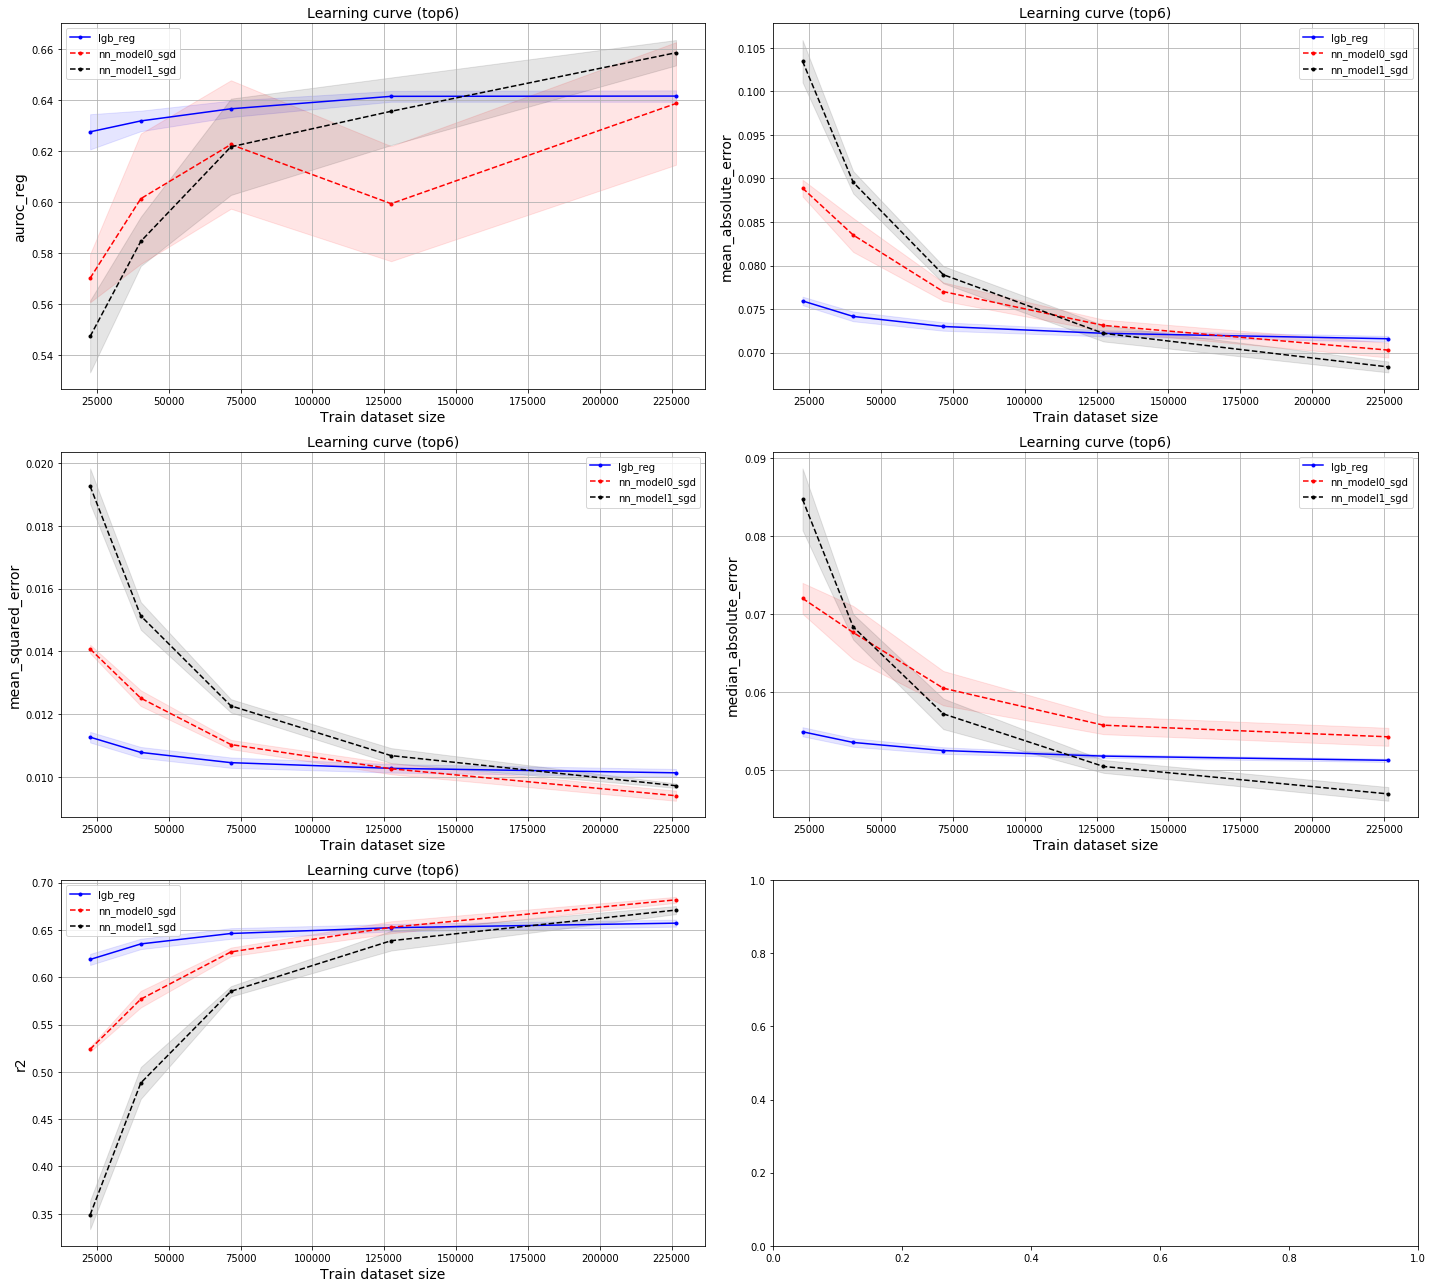

In [11]:
# Same metric for different runs
tmp = pd.read_csv(runs['run1'][1])
metrics = tmp['metric'].unique()

colors = ['b', 'r', 'k', 'c', 'm', 'g']
title = None
fontsize=14
figsize=(20,18)

ncols=2
nrows=int(np.ceil(len(set(metrics))/ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
ax = ax.ravel()

for i, met_name in enumerate(metrics):
        
    #plt.figure(figsize=figsize)
        
    for j, (k, v) in enumerate(runs.items()):
        df = pd.read_csv(runs[k][1])
        cvf = len([c for c in df.columns.tolist() if c[0]=='f']) # get the number of cv_folds
        
        dfm = df[df['metric']==met_name].reset_index(drop=True)  # scores for a specific metric 

        tr_sizes  = dfm['tr_size'].unique()
        te_scores = dfm.loc[dfm['tr_set']==False, dfm.columns[-cvf:]]

        te_scores_mean = np.mean(te_scores, axis=1)
        te_scores_std  = np.std(te_scores, axis=1)
        
        # plt.plot(tr_sizes, te_scores_mean, '.--', color=colors[j], label=runs[k][0])
        linestype = dd[ runs[k][0].split('_')[-1] ]
        #plt.plot(tr_sizes, te_scores_mean, marker='.', linestyle=linestype, color=colors[j], label=runs[k][0])
        ax[i].plot(tr_sizes, te_scores_mean, marker='.', linestyle=linestype, color=colors[j], label=runs[k][0])
        #plt.fill_between(tr_sizes, te_scores_mean - te_scores_std, te_scores_mean + te_scores_std, alpha=0.1, color=colors[j])
        ax[i].fill_between(tr_sizes, te_scores_mean - te_scores_std, te_scores_mean + te_scores_std, alpha=0.1, color=colors[j])
        
        #plt.title(f'Learning curve ({src_name})', fontsize=fontsize)
        ax[i].set_title(f'Learning curve ({src_name})', fontsize=fontsize)
        
        #plt.xlabel('Train dataset size', fontsize=fontsize)
        ax[i].set_xlabel('Train dataset size', fontsize=fontsize)
        #plt.ylabel(met_name, fontsize=fontsize)
        ax[i].set_ylabel(met_name, fontsize=fontsize)
        #plt.legend(loc='best', frameon=True)
        ax[i].legend(loc='best', frameon=True)

    plt.tight_layout()
    #plt.grid(True)
    ax[i].grid(True)
    
    if save:
        plt.savefig( outdir/(src_name+'_'+met_name+'.png') )

In [8]:
# https://github.com/bckenstler/CLR

In [9]:
base_lr=0.0001  # 0.001
max_lr=0.001    # 0.006
step_size=2000.
mode='exp_range'
gamma=0.99994
scale_fn=None
scale_mode='cycle'

In [20]:
batch = 32
datasize = 20386
iterations = 20386/batch

In [39]:
cycle = np.floor(1+iterations/(2*step_size))
x = np.abs(iterations/step_size - 2*cycle + 1)
lr= base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))*gamma**(iterations)